In [1]:
#to remove emojis
!pip install clean-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.5 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=75007cce2417be7a72bf15775a0b3c10ec95ad2d1e76068fda8d868fa5db9829
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.5.0
    Uninstalling emoji-2.5.0:
      Successfully uninstalled emoji-2.5.0


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tweets/tweets.csv
/kaggle/input/final-depression-dataset/final_depression_dataset.csv


In [3]:
# standard
import numpy as np
import pandas as pd

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# string functions
import string

# wordcloud
from wordcloud import WordCloud

# NLTK
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from snowballstemmer import stemmer
from nltk.stem.porter import PorterStemmer

# from cleantext import clean
import re

# ML
# import h2o
# from h2o.estimators import H2ORandomForestEstimator
# from h2o.estimators import H2OGradientBoostingEstimator

# other stuff
from collections import Counter
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
# Load the tokenizer.
tokenizer = BertTokenizer.from_pretrained("asafaya/bert-base-arabic")
import torch

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
pd.set_option('display.max_colwidth', None) # we want to see full cell contents

In [5]:
stop_words = stopwords.words('arabic')

In [6]:
# load data (input is an CSV file)
df = pd.read_csv('../input/final-depression-dataset/final_depression_dataset.csv')
df.head()

,Label,Tweets
0,2,#الهلال_الاهلي فوز هلالي مهم الحمد لله 💙 زوران كان بيسلم المباراة بعد تبديل كارييو بإنتظار الإتحاد بكرة يارب يار…
1,2,صباحك خيرات ومسرات 🌸
2,2,"#تأمل قال الله ﷻ :- _*​﴿بواد غير ذي زرع ﴾*_ 💫💫 ✍ "" ~ومع ذلك هتف بالدعاء ﴿وارزقهم من الثمرات ﴾ مهماكانت ظرو…"
3,2,😂😂 يا جدعان الرجاله اللي فوق ال دول خطر ع تويتر وربنا 😂مش اسلوب كل يومين يدخلي واحد قد جدي علشان يشقطني 😒 😹و عند…
4,2,رساله صباحيه : 💛 اللهم اسألك التوفيق في جميع امورنا واكتب لنا الفردوس نحن ووالدينا وجميع موتى المسلمين برحمتك يا ارحم الراحمين


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13517 entries, 0 to 13516
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   13517 non-null  int64 
 1   Tweets  13510 non-null  object
dtypes: int64(1), object(1)
memory usage: 211.3+ KB


In [8]:
df.dropna(inplace = True)

In [9]:
df.isna().sum()

Label     0
Tweets    0
dtype: int64

In [10]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations
porter = PorterStemmer()

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida

                         """, re.VERBOSE)

def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text


def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)


def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def preprocess_tweet(text):

  # (1) Cleaning text
  text = remove_diacritics(text)
  text = remove_punctuations(text)
  text = remove_repeating_char(text)
  text = remove_emojis(text)
  
  # (3) Removing stopwords
  text = [word for word in text if word not in stop_words]

  # (4) Stemming
  text = [porter.stem(word) for word in text]
    
 # (5)  call_model

 # (6)  extract output

  return text

In [11]:
for index, row in df.iterrows():
    df.loc[index, 'Tweets'] = remove_emojis(row['Tweets'])
df.head(20)

,Label,Tweets
0,2,#الهلال_الاهلي فوز هلالي مهم الحمد لله زوران كان بيسلم المباراة بعد تبديل كارييو بإنتظار الإتحاد بكرة يارب يار…
1,2,صباحك خيرات ومسرات
2,2,"#تأمل قال الله :- _*​بواد غير ذي زرع *_ "" ~ومع ذلك هتف بالدعاء وارزقهم من الثمرات مهماكانت ظرو…"
3,2,يا جدعان الرجاله اللي فوق ال دول خطر ع تويتر وربنا مش اسلوب كل يومين يدخلي واحد قد جدي علشان يشقطني و عند…
4,2,رساله صباحيه : اللهم اسألك التوفيق في جميع امورنا واكتب لنا الفردوس نحن ووالدينا وجميع موتى المسلمين برحمتك يا ارحم الراحمين
5,2,اجيال القووه والصمود والتحدي اجيال المستقبل وابطال محمد الحزم والعزم
6,2,البنت اذا شافت امها معصبة تقوم ترتب البيت لا اراديا سياسة امتصاص الغضب
7,2,جدا الصراحه بس المغرب قدها
8,2,صباح الياسمين
9,2,لسنا مجبرين على تبرير المواقف لمن يسيء الظن بنا ، من يعرفنا جيدا يفھمنا جيدا ، فالعين تكذب نفسھا أن أحبت والأذ…


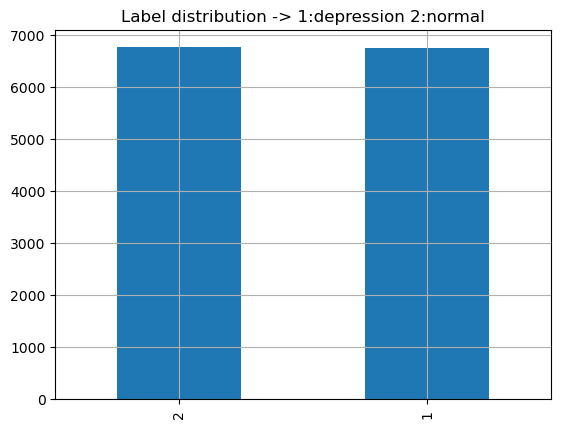

In [12]:
# plot target (1 ~ depression/normal)
df.Label.value_counts().plot(kind='bar')
plt.title('Label distribution -> 1:depression 2:normal')
plt.grid()
plt.show()

In [13]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
# For every sentence...
for tweet in df['Tweets']:
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 50,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(df['Label'])

# Print sentence 0, now as a list of IDs.
print('Original: ', df['Tweets'][2])
print('Token IDs:', input_ids[2])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


KeyError: 1599

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size],generator=torch.Generator().manual_seed(87))

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

#For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained("asafaya/bert-base-arabic", num_labels = 40)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
epochs = 4
for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            # Report progress.
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels).values()
        # from the tensor.
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        # Update the learning rate.
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader) 

In [ ]:
    print("")
    print("Running Validation...")
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels).values()
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
        }
    )

print("")

In [ ]:
from transformers import AutoTokenizer

tokenizer.save_pretrained('results/tokenizer/')

In [ ]:
# from transformers import get_linear_schedule_with_warmup

# # Number of training epochs. The BERT authors recommend between 2 and 4. 
# # We chose to run for 4, but we'll see later that this may be over-fitting the
# # training data.
# epochs = 4

# # Total number of training steps is [number of batches] x [number of epochs]. 
# # (Note that this is not the same as the number of training samples).
# total_steps = len(train_dataloader) * epochs

# # Create the learning rate scheduler.
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps = 0, # Default value in run_glue.py
#                                             num_training_steps = total_steps)

In [ ]:
!zip -r file.zip 'results/tokenizer/'

In [ ]:
def define_model(length, vocab_size,embed_dim=100,num_heads=3,ff_dim=64,dropout_prob=0.1):
  inputs = layers.Input(shape=(length,))
  embedding_layer = Embeddinginput_dim =len(my_vocab), output_dim=embed_dim,weights=[my_vocab.embedding_matrix], input_length=length,trainable=False #TokenAndPositionEmbedding(length, vocab_size, embed_dim)
  x = embedding_layer(inputs)
  transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
  x = transformer_block(x)
  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dropout(dropout_prob)(x)
  x = layers.Dense(128, activation="relu")(x)
  x = layers.Dropout(dropout_prob)(x)
  outputs = layers.Dense(40, activation="softmax")(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model